In [8]:
import sys
sys.path.append('../')

import numpy as np
import networkx as nx
import itertools
import torch
import torch.nn.functional as F
import torch_sparse
import random 
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from models.sheaf_base import SheafDiffusion
from models.cont_models import GraphLaplacianDiffusion, DiagSheafDiffusion, BundleSheafDiffusion
from lib.laplace import get_2d_oracle_rotation_angles
from torch_geometric.nn.dense.linear import Linear
from scipy import linalg
from torch_geometric.utils import to_dense_adj, from_networkx
from torch_geometric.nn.conv import GCNConv
from data.heterophilic import generate_random_splits
from models.orthogonal import Orthogonal
from models import laplacian_builders as lb
from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

import matplotlib as mpl
sns.set(font_scale=1.3) 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Create graph dataset

In [11]:
def create_graph_dataset(num_nodes=99, input_features=3, inter_p=1.0, classes=3, num_edges=1000):
    assert 0 <= inter_p <= 1.0
    # We randomly generate graphs until we produce a connected one
    graph = nx.Graph()

    # Partition the graph into two sets. 
    nodes = np.arange(0, num_nodes).reshape(classes, -1)
    graph.add_nodes_from(nodes.flatten())

    # Randomly generate edges between nodes
    edges = []
    for _ in range(num_edges):
        current_class = random.randint(0, classes-1)
        nodes_from_other_classes = np.concatenate((nodes[:current_class, :],nodes[current_class+1:, :]))
        v_node = random.choice(nodes[current_class])

        sample = np.random.uniform(0, 1)
        if sample <= inter_p:
            u_node = random.choice(nodes_from_other_classes.flatten())
        else:
            u_node = random.choice(nodes[current_class])
        if u_node != v_node:
            edges.append((v_node, u_node))
    graph.add_edges_from(edges)
    assert nx.is_connected(graph)
    
    # Convert the graph to a PyTorch geometric data object
    data = from_networkx(graph)

    # Add dummy features to the graph
    x_V = torch.empty(num_nodes // classes, input_features).normal_(mean=-0.6,std=0.4)
    x_U = torch.empty(num_nodes // classes, input_features).normal_(mean=0.0,std=0.4)
    x_W = torch.empty(num_nodes // classes, input_features).normal_(mean=0.6,std=0.4)

    x = torch.cat((x_V, x_U, x_W), dim=0)
    data.x = x

    # Add labels
    y = torch.arange(classes).view(-1, 1).tile(1,num_nodes // classes).view(-1, )
    data.y = y
    
    # Meta
    data.num_nodes = num_nodes
    data.in_features = input_features
    
    
    return data, graph

In [12]:
inter_p=0.8
data, _ = create_graph_dataset(inter_p=inter_p)
data = generate_random_splits(data, num_classes=3, val_rate=0.0, train_rate=0.8)

#### Train Laplacian difussion models

In [13]:
times = torch.arange(0, 11, step=1.0)
seeds = 3

args = {
    'hidden_channels': 10,
    'layers': -1,
    'device': torch.device('cpu'),
    'normalised': True,
    'deg_normalised': False,
    'linear': True,
    'input_dropout': 0.0,
    'dropout': 0.0,
    'left_weights': False,
    'right_weights': False,
    'use_act': False,
    'second_linear': False,
    'add_lp': False,
    'add_hp': False,
    'sheaf_act': 'tanh',
    'tol_scale': 1.0,
    'int_method': 'dopri5',
    'step_size': None,
    'max_iters': None,
    'tol_scale_adjoint': 1.0,
    'adjoint_method': 'euler',
    'adjoint_step_size': None,
    'edge_weights': False,
    'orth': 'householder',
    'graph_size': data.num_nodes,
    'input_dim': 3,
    'output_dim': 3,
    'adjoint': False,
}

In [17]:
def eval_model(model, data, mask):
    model.eval()
    pred = model(data.x).argmax(dim=1)
    correct = (pred[mask] == data.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc

#### Train 1D Sheaf Difussion Model

In [18]:
sheaf_train_res, sheaf_test_res = [], []
for seed in range(seeds):
    sheaf_train_acc, sheaf_test_acc = [], []
    for t in times:
        args['max_t'] = t
        args['d'] = 1

        model = DiagSheafDiffusion(data.edge_index, args) 
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

        model.train()
        for epoch in range(201):
            optimizer.zero_grad()
            out = model(data.x)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0 and epoch > 0:
                print(f"Epoch: {epoch} | Loss: {loss.item()}")

        train_acc = eval_model(model, data, data.train_mask)
        test_acc = eval_model(model, data, data.test_mask)
        print(f'Time: {t.item()}')
        print('Train Accuracy: {:.4f}'.format(train_acc))
        print('Test Accuracy: {:.4f}'.format(test_acc))

        sheaf_train_acc.append(train_acc)
        sheaf_test_acc.append(test_acc)
    sheaf_train_res.append(sheaf_train_acc)
    sheaf_test_res.append(sheaf_test_acc)

Epoch: 100 | Loss: 0.2453201562166214
Epoch: 200 | Loss: 0.211838036775589
Time: 0.0
Train Accuracy: 0.8974
Test Accuracy: 0.8571
Epoch: 100 | Loss: 0.2181030958890915
Epoch: 200 | Loss: 0.16535790264606476
Time: 1.0
Train Accuracy: 0.9231
Test Accuracy: 0.8571
Epoch: 100 | Loss: 0.20627205073833466
Epoch: 200 | Loss: 0.16047148406505585
Time: 2.0
Train Accuracy: 0.9231
Test Accuracy: 0.8571
Epoch: 100 | Loss: 0.2576482892036438
Epoch: 200 | Loss: 0.17749840021133423
Time: 3.0
Train Accuracy: 0.9231
Test Accuracy: 0.8571
Epoch: 100 | Loss: 0.2041219025850296
Epoch: 200 | Loss: 0.16186778247356415
Time: 4.0
Train Accuracy: 0.9231
Test Accuracy: 0.8571
Epoch: 100 | Loss: 0.2796839475631714
Epoch: 200 | Loss: 0.1963586062192917
Time: 5.0
Train Accuracy: 0.9231
Test Accuracy: 0.9048
Epoch: 100 | Loss: 0.19318567216396332
Epoch: 200 | Loss: 0.16513805091381073
Time: 6.0
Train Accuracy: 0.9231
Test Accuracy: 0.8571
Epoch: 100 | Loss: 0.25997060537338257
Epoch: 200 | Loss: 0.17318515479564667

#### Train 2D Sheaf Difussion Model

In [19]:
sheaf2d_train_res, sheaf2d_test_res = [], []
for seed in range(seeds):
    sheaf2d_train_acc, sheaf2d_test_acc = [], []
    for t in times:
        args['max_t'] = t
        args['edge_weights'] = True
        args['d'] = 2
        args['orth'] = 'householder'
        args['linear'] = True
        args['hidden_channels'] = 5
        args['dropout'] = 0.0

        model = BundleSheafDiffusion(data.edge_index, args) 
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

        model.train()
        for epoch in range(201):
            optimizer.zero_grad()
            out = model(data.x)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0 and epoch > 0:
                print(f"Epoch: {epoch} | Loss: {loss.item()}")

        train_acc = eval_model(model, data, data.train_mask)
        test_acc = eval_model(model, data, data.test_mask)
        print(f'Time: {t.item()}')
        print('Train Accuracy: {:.4f}'.format(train_acc))
        print('Test Accuracy: {:.4f}'.format(test_acc))

        sheaf2d_train_acc.append(train_acc)
        sheaf2d_test_acc.append(test_acc)
    sheaf2d_train_res.append(sheaf2d_train_acc)
    sheaf2d_test_res.append(sheaf2d_test_acc)

Epoch: 100 | Loss: 0.21773993968963623
Epoch: 200 | Loss: 0.20860221982002258
Time: 0.0
Train Accuracy: 0.9103
Test Accuracy: 0.8571
Epoch: 100 | Loss: 0.2200922667980194
Epoch: 200 | Loss: 0.20872658491134644
Time: 1.0
Train Accuracy: 0.9103
Test Accuracy: 0.8571
Epoch: 100 | Loss: 0.1513410210609436
Epoch: 200 | Loss: 0.1068522036075592
Time: 2.0
Train Accuracy: 0.9487
Test Accuracy: 0.9048
Epoch: 100 | Loss: 0.15630626678466797
Epoch: 200 | Loss: 0.11512342095375061
Time: 3.0
Train Accuracy: 0.9615
Test Accuracy: 0.9524
Epoch: 100 | Loss: 0.18272675573825836
Epoch: 200 | Loss: 0.07535462081432343
Time: 4.0
Train Accuracy: 1.0000
Test Accuracy: 0.9048
Epoch: 100 | Loss: 0.1557009518146515
Epoch: 200 | Loss: 0.11056078225374222
Time: 5.0
Train Accuracy: 0.9744
Test Accuracy: 0.8571
Epoch: 100 | Loss: 0.14006651937961578
Epoch: 200 | Loss: 0.06134048476815224
Time: 6.0
Train Accuracy: 1.0000
Test Accuracy: 0.9524
Epoch: 100 | Loss: 0.1441713571548462
Epoch: 200 | Loss: 0.10301324725151

#### Oracle Sheaf

In [20]:
class StandardODEFunc(nn.Module):
    """Implements Laplacian-based diffusion."""

    def __init__(self, d, L):
        super(StandardODEFunc, self).__init__()
        self.d = d
        self.L = L
        
    def forward(self, t, x):
        return torch_sparse.spmm(self.L[0], self.L[1], x.size(0), x.size(0), -x)
    
class ODEBlock(nn.Module):
    """Module performing the ODE Integration."""

    def __init__(self, odefunc, t, opt):
        super(ODEBlock, self).__init__()
        self.t = t
        self.opt = opt
        self.odefunc = odefunc
        self.set_tol()

    def set_tol(self):
        self.atol = self.opt['tol_scale'] * 1e-7
        self.rtol = self.opt['tol_scale'] * 1e-9
        if self.opt['adjoint']:
            self.atol_adjoint = self.opt['tol_scale_adjoint'] * 1e-7
            self.rtol_adjoint = self.opt['tol_scale_adjoint'] * 1e-9

    def reset_tol(self):
        self.atol = 1e-7
        self.rtol = 1e-9
        self.atol_adjoint = 1e-7
        self.rtol_adjoint = 1e-9

    def forward(self, x):
        if self.opt["adjoint"] and self.training:
            z = odeint_adjoint(
                self.odefunc, x, self.t,
                method=self.opt['int_method'],
                options=dict(step_size=self.opt['step_size'], max_iters=self.opt['max_iters']),
                adjoint_method=self.opt['adjoint_method'],
                adjoint_options=dict(step_size=self.opt['adjoint_step_size'], max_iters=self.opt['max_iters']),
                atol=self.atol,
                rtol=self.rtol,
                adjoint_atol=self.atol_adjoint,
                adjoint_rtol=self.rtol_adjoint)
        else:
            z = odeint(
                self.odefunc, x, self.t,
                method=self.opt['int_method'],
                options=dict(step_size=self.opt['step_size'], max_iters=self.opt['max_iters']),
                atol=self.atol,
                rtol=self.rtol)
        return z[1]

In [21]:
class TwoDimOracleSheafDiffusion(SheafDiffusion):
    """Performs diffusion using a sheaf Laplacian with diagonal restriction maps."""

    def __init__(self, edge_index, labels, args):
        super(TwoDimOracleSheafDiffusion, self).__init__(edge_index, args)
        assert args['d'] == 2
        self.labels = labels
        
        self.lin1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.lin2 = nn.Linear(self.hidden_dim, self.output_dim) 
        
        angles = get_2d_oracle_rotation_angles(edge_index, labels)
        laplacian_builder = lb.NormConnectionLaplacianBuilder(
            self.graph_size, edge_index, d=self.d, orth_map='euler')
        self.L, _ = laplacian_builder(angles)

        self.odefunc = StandardODEFunc(self.d, self.L)
        self.odeblock = ODEBlock(self.odefunc, self.time_range, args)
                

    def forward(self, x):
        x = self.lin1(x)
        if self.t > 0:
            x = x.view(self.graph_size * self.final_d, -1)
            x = self.odeblock(x)
        
        x = x.view(self.graph_size, -1)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

In [22]:
oracle_train_res, oracle_test_res = [], []
for seed in range(1):
    oracle_train_acc, oracle_test_acc = [], []
    for t in times:
        args['max_t'] = t
        args['edge_weights'] = False
        args['d'] = 2
        args['orth'] = 'euler'

        model = TwoDimOracleSheafDiffusion(data.edge_index, data.y, args) 
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

        model.train()
        for epoch in range(201):
            optimizer.zero_grad()
            out = model(data.x)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0 and epoch > 0:
                print(f"Epoch: {epoch} | Loss: {loss.item()}")

        train_acc = eval_model(model, data, data.train_mask)
        test_acc = eval_model(model, data, data.test_mask)
        print('Train Accuracy: {:.4f}'.format(train_acc))
        print('Test Accuracy: {:.4f}'.format(test_acc))

        oracle_train_acc.append(train_acc)
        oracle_test_acc.append(test_acc)
    oracle_train_res.append(oracle_train_acc)
    oracle_test_res.append(oracle_test_acc)

Epoch: 100 | Loss: 0.2187853306531906
Epoch: 200 | Loss: 0.20888257026672363
Train Accuracy: 0.9103
Test Accuracy: 0.8571
Epoch: 100 | Loss: 0.013726911507546902
Epoch: 200 | Loss: 0.005281628109514713
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.009058533236384392
Epoch: 200 | Loss: 0.0038265998009592295
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.008376240730285645
Epoch: 200 | Loss: 0.0036477537360042334
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.008483479730784893
Epoch: 200 | Loss: 0.0035297709982842207
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.008493578992784023
Epoch: 200 | Loss: 0.0034886938519775867
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.007038770709186792
Epoch: 200 | Loss: 0.003257313510403037
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.00848724041134119
Epoch: 200 | Loss: 0.0035717682912945747
Train Accuracy: 1.0000
Test Accuracy: 1.0000

#### Plotting Results

In [23]:
def agg_results(res):
    res = np.array(res)
    mean = np.mean(res, axis=0)
    std = np.std(res, axis=0) 
    return mean, std

In [24]:
# Performance as a function of the difussion time
sheaf_mean_train, sheaf_std_train = agg_results(sheaf_train_res)
sheaf_mean_test, sheaf_std_test = agg_results(sheaf_test_res) 

sheaf2d_mean_train, sheaf2d_std_train = agg_results(sheaf2d_train_res)
sheaf2d_mean_test, sheaf2d_std_test = agg_results(sheaf2d_test_res)

oracle_mean_train, oracle_std_train = agg_results(oracle_train_res)
oracle_mean_test, oracle_std_test = agg_results(oracle_test_res)

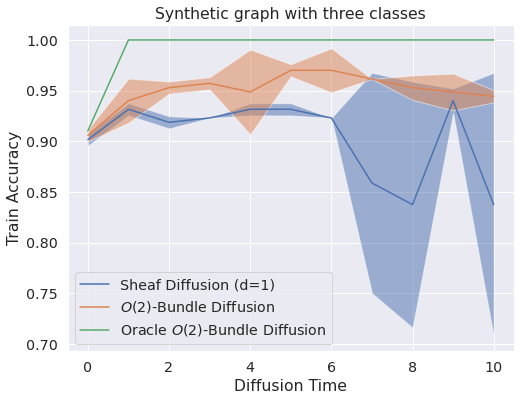

In [40]:
plt.figure(figsize=(8, 6))

plt.plot(times, sheaf_mean_train, label="Sheaf Diffusion (d=1)")
plt.fill_between(times, sheaf_mean_train - sheaf_std_train, np.clip(sheaf_mean_train + sheaf_std_train, 0.0, 1.0), alpha=0.5)

plt.plot(times, sheaf2d_mean_train, label=r"$O(2)$-Bundle Diffusion")
plt.fill_between(times, sheaf2d_mean_train - sheaf2d_std_train, np.clip(sheaf2d_mean_train + sheaf2d_std_train, 0.0, 1.0), alpha=0.5)

plt.plot(times, oracle_mean_train, label="Oracle $O(2)$-Bundle Diffusion")
plt.fill_between(times, oracle_mean_train - oracle_std_train, np.clip(oracle_mean_train + oracle_std_train, 0.0, 1.0), alpha=0.5)

plt.legend()
plt.title(fr"Synthetic graph with three classes")
plt.xlabel('Diffusion Time')
plt.ylabel('Train Accuracy')
plt.savefig("img/2d_biartite.pdf", bbox_inches='tight')
plt.show()

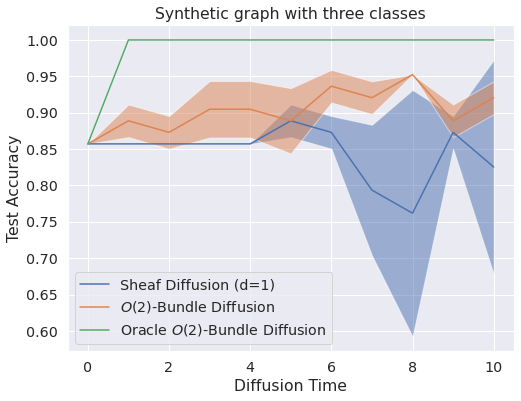

In [41]:
plt.figure(figsize=(8, 6))

plt.plot(times, sheaf_mean_test, label="Sheaf Diffusion (d=1)")
plt.fill_between(times, sheaf_mean_test - sheaf_std_test, np.clip(sheaf_mean_test + sheaf_std_test, 0.0, 1.0), alpha=0.5)

plt.plot(times, sheaf2d_mean_test, label=r"$O(2)$-Bundle Diffusion")
plt.fill_between(times, sheaf2d_mean_test - sheaf2d_std_test, np.clip(sheaf2d_mean_test + sheaf2d_std_test, 0.0, 1.0), alpha=0.5)

plt.plot(times, oracle_mean_test, label="Oracle $O(2)$-Bundle Diffusion")
plt.fill_between(times, oracle_mean_test - oracle_std_test, oracle_mean_test + oracle_std_test, alpha=0.5)

plt.legend()
plt.title(fr"Synthetic graph with three classes")
plt.xlabel('Diffusion Time')
plt.ylabel('Test Accuracy')
plt.savefig("img/2d_biartite_test.pdf", bbox_inches='tight')
plt.show()

#### Analyzing the Learned Laplacian

In [61]:
# Define the model
args['max_t'] = 8.0
args['d'] = 2
args['orth'] = 'euler'
model = BundleSheafDiffusion(data.edge_index, args) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

# Check how the entries of the Laplacian look like in the beginning
maps = model.sheaf_learner(model.lin1(data.x), data.edge_index)
_, non_diag_vals_before = model.laplacian_builder(maps)
param_before = model.sheaf_learner(model.lin1(data.x).view(model.graph_size, -1), data.edge_index)

model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = model(data.x)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 and epoch > 0:
        print(f"Epoch: {epoch} | Loss: {loss.item()}")

train_acc = eval_model(model, data, data.train_mask)
test_acc = eval_model(model, data, data.test_mask)
print('Train Accuracy: {:.4f}'.format(train_acc))
print('Test Accuracy: {:.4f}'.format(test_acc))

# Check how the entries of the Laplacian look like in the beginning
maps = model.sheaf_learner(model.lin1(data.x), data.edge_index)
_, non_diag_vals_after = model.laplacian_builder(maps)
param_after = model.sheaf_learner(model.lin1(data.x).view(model.graph_size, -1), data.edge_index)

Epoch: 100 | Loss: 0.19045358896255493
Epoch: 200 | Loss: 0.17303679883480072
Epoch: 300 | Loss: 0.16791409254074097
Train Accuracy: 0.9231
Test Accuracy: 0.9048


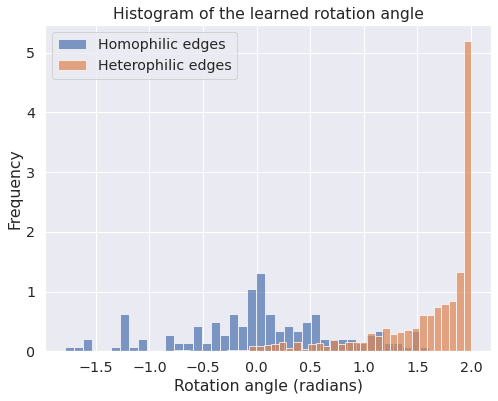

In [64]:
# The structure of the learned Laplacian 
import math
angle_before = torch.atan2(-non_diag_vals_before[:, 1, 0], -non_diag_vals_before[:, 0, 0])
angle_after = torch.atan2(-non_diag_vals_after[:, 1, 0], -non_diag_vals_after[:, 0, 0]) 


left_idx, right_idx = model.laplacian_builder.left_right_idx
row, _ = data.edge_index
row, col = row[left_idx], row[right_idx]
intra_angle = angle_after[data.y[row] == data.y[col]]
inter_angle = angle_after[data.y[row] != data.y[col]]

plt.figure(figsize=(8, 6))
plt.hist(intra_angle.detach().numpy(), bins=40, alpha=0.7, label='Homophilic edges', density=True)
plt.hist(inter_angle.detach().numpy(), bins=40, alpha=0.7, label='Heterophilic edges', density=True)

plt.legend()
plt.title(fr"Histogram of the learned rotation angle")
plt.xlabel('Rotation angle (radians)')
plt.ylabel('Frequency')
plt.savefig("img/2d_transport_hist.pdf", bbox_inches='tight')
plt.show()